In [1]:
from datetime import datetime
from lassort import load, localAssortF
import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sparse

from networkx.generators.community import stochastic_block_model as sbm
from lassort.localassort import calculateRWRrange
from networkx.algorithms.community import modularity
from matplotlib import pyplot as plt

In [2]:
N = 800
p = [[.1,.05], [.05, .1]]

def run_analysis(
    s0, 
    N=N, 
    p=p):
    sizes = [s0, N - s0]
    G = sbm(sizes, p,seed=43)
    E = nx.convert_matrix.to_pandas_edgelist(G).values
    M = np.hstack([np.zeros(sizes[0]), np.ones(sizes[1])])

    assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

    # average score for first group
    T0 = assortT[:sizes[0]].mean()
    # average score for second group
    T1 = assortT[sizes[0]:].mean()

    assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1), weight_a=True)
    
    # average score for first group
    T0_new = assortT[:sizes[0]].mean()
    # average score for second group
    T1_new = assortT[sizes[0]:].mean()
    

    # modularity of partition
    A = nx.convert_matrix.to_scipy_sparse_matrix(G)

    # this is the stub count, or the edge count times 2
    m2 = A.sum()

    # intra-community edge density for each group
    e0 = A[:sizes[0], :sizes[0]].sum() / m2
    e1 = A[sizes[0]:, sizes[0]:].sum() / m2

    # degree proportion for each group
    a0 = A[:sizes[0],:].sum() / m2
    a1 = A[sizes[0]:,:].sum() / m2

    # modularity score
    Q = e0 -a0**2 + e1 - a1**2
    
    return (s0, Q, T0, T1, T0_new, T1_new)

In [3]:
run_analysis(400)

(0.16341821111296662,
 0.32348322852365763,
 0.3310031048279065,
 0.004915472473567144,
 0.0028220338657599753)

In [4]:
run_analysis(20)

(0.0009664888885714262,
 -18.796916799837543,
 0.2827296481225326,
 0.18188823417325234,
 -0.2232045499184806)

In [5]:
s0s = pd.Series(np.arange(20, 401, 20))
results = s0s.apply(run_analysis)

In [17]:
columns = ["Q", "T0", "T1", "T0_new", "T1_new"]
df = pd.DataFrame(
    results.to_list(),
    columns=columns
)
df["s0"] = s0s

df_rev = df.copy()
df_rev["s0"] = N - df_rev.s0
df_rev.columns = ["Q", "T1", "T0", "T1_new", "T0_new", "s0"]
df = pd.concat([df,df_rev], axis=0).sort_values("s0").reset_index(drop=True)

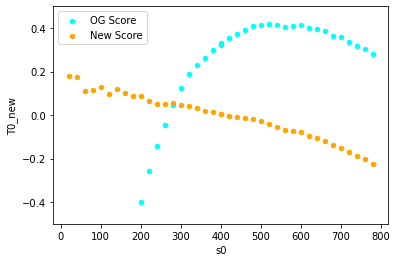

In [18]:
ax = df.plot(kind="scatter", x="s0", y="T0", color="cyan",ylim=[-0.5, 0.5])
df.plot(kind="scatter", x="s0", y="T0_new", ax=ax, color="orange")
ax.legend(["OG Score", "New Score"])

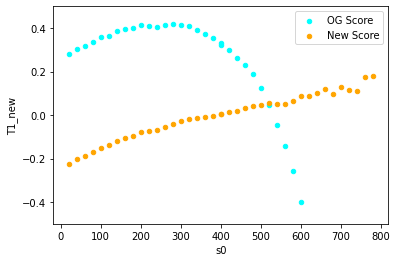

In [19]:
ax = df.plot(kind="scatter", x="s0", y="T1", color="cyan",ylim=[-0.5, 0.5])
df.plot(kind="scatter", x="s0", y="T1_new", ax=ax, color="orange")
ax.legend(["OG Score", "New Score"])

In [23]:
df.T0_new.mean()

-0.004653149541953072

In [24]:
df.T1_new.mean()

-0.00465314954195307

Okay cool, so this new score slowly decreases as the group size increases-- it's easier to be assortative in a small group.   It also appears to have a pretty small dynamic range but we are just taking the mean and also there isn't meaningful variation within the group here.

Maybe we should construct a better synthetic example with actual local differences in assortativity.

In [256]:
N = 400
k = 5 # mean degree

# population gender and sexual orientation breakdowns
# from https://news.gallup.com/poll/329708/lgbt-identification-rises-latest-estimate.aspx
# group sizes were adjusted to make things easier

gf = .03 * N / 2
bf = .05 * N / 2
sf = .92 * N / 2
gm = .03 * N / 2
bm = .03 * N / 2
sm = .94 * N / 2

sizes = np.array([gf, bf, sf, gm, bm, sm])
sizes.sum()

400.0

In [257]:
sums = sizes * k
sums

array([ 30.,  50., 920.,  30.,  30., 940.])

In [258]:
sizes[:3].sum()

200.0

In [259]:
# divide up the edges
omega = np.zeros(shape=(6,6))

# fix things
omega[0,0] = 0.95 * sums[0]
omega[3,3] = 0.95 * sums[3]

# size of overlap must be determined
# from the smaller group size to avoid weirdness
omega[1,5] = 0.4 * sums[1]
omega[5,1] = omega[1,5]

omega[2,4] = 0.4 * sums[4]
omega[4,2] = omega[2,4]

# deduce other values
omega[1,0] = sums[0] - omega[0,0]
omega[0,1] = omega[1,0]

omega[3,4] = sums[3] - omega[3,3]
omega[4,3] = omega[3,4]

# bm -- split remaining edges equally between
# bm and bf
omega[1,4] = (sums[4] - omega[4].sum()) / 2
omega[4,1] = omega[1,4]

omega[4,4] = omega[1,4]

omega[1,1] = sums[1] - omega[1].sum()

omega[5,2] = ((sums[5] - omega[5].sum()) + (sums[2] - omega[2].sum()))/2
omega[2,5] = omega[5,2]

omega

array([[ 28.5 ,   1.5 ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  1.5 ,  20.25,   0.  ,   0.  ,   8.25,  20.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,  12.  , 914.  ],
       [  0.  ,   0.  ,   0.  ,  28.5 ,   1.5 ,   0.  ],
       [  0.  ,   8.25,  12.  ,   1.5 ,   8.25,   0.  ],
       [  0.  ,  20.  , 914.  ,   0.  ,   0.  ,   0.  ]])

In [260]:
omega.sum(axis=0)

array([ 30.,  50., 926.,  30.,  30., 934.])

In [261]:
sums

array([ 30.,  50., 920.,  30.,  30., 940.])

In [262]:
omega.tolist()

[[28.5, 1.5, 0.0, 0.0, 0.0, 0.0],
 [1.5, 20.25, 0.0, 0.0, 8.25, 20.0],
 [0.0, 0.0, 0.0, 0.0, 12.0, 914.0],
 [0.0, 0.0, 0.0, 28.5, 1.5, 0.0],
 [0.0, 8.25, 12.0, 1.5, 8.25, 0.0],
 [0.0, 20.0, 914.0, 0.0, 0.0, 0.0]]

In [263]:
# to do an SBM we need the number of possible edges between each group
# this is different on vs. off the diagonal

p = omega.copy()

for i in range(6):
    # TODO: factor of 2 here?
    p[i, i] = omega[i,i] / (sizes[i] * (sizes[i] - 1))
    
    for j in range(i, 6):
        p[i,j] = omega[i,j] / (sizes[i] * sizes[j])
        p[j,i] = p[i,j]
        
p

array([[0.79166667, 0.025     , 0.        , 0.        , 0.        ,
        0.        ],
       [0.025     , 0.2025    , 0.        , 0.        , 0.1375    ,
        0.0106383 ],
       [0.        , 0.        , 0.        , 0.        , 0.01086957,
        0.02642229],
       [0.        , 0.        , 0.        , 0.79166667, 0.04166667,
        0.        ],
       [0.        , 0.1375    , 0.01086957, 0.04166667, 0.22916667,
        0.        ],
       [0.        , 0.0106383 , 0.02642229, 0.        , 0.        ,
        0.        ]])

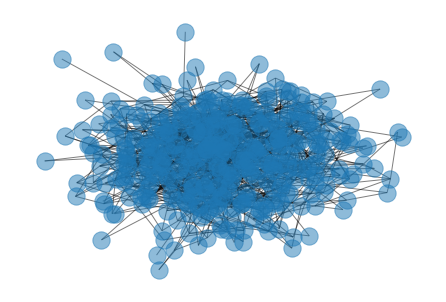

In [264]:
seed = 23
G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

cc = max(nx.connected_components(G), key=len)
G = G.subgraph(cc).copy()

pos = nx.spring_layout(G, seed=seed,iterations=8)

nx.draw(G,pos, alpha=0.5)

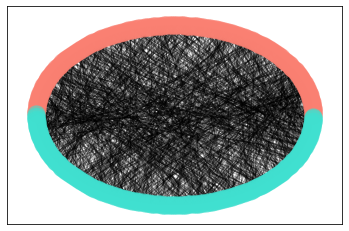

In [270]:
nl = list(G.nodes)
f = [n for n in nl if n < N/2]
m = [n for n in nl if n >= N/2]

nx.draw_networkx_nodes(G,pos, nodelist=f,alpha=0.5, node_color="salmon")
nx.draw_networkx_nodes(G,pos, nodelist=m,alpha=0.5, node_color="turquoise")
nx.draw_networkx_edges(G, pos, alpha=0.3)

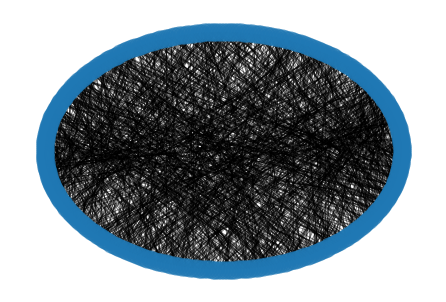

In [269]:
pos = nx.circular_layout(G)
nx.draw(G,pos, alpha=0.5)

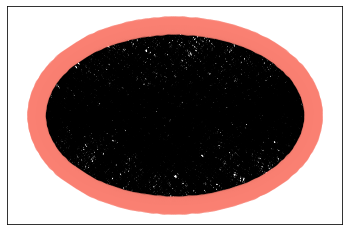

In [267]:
nl = list(G.nodes)
f = [n for n in nl if n < 500]
m = [n for n in nl if n >= 500]

pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G,pos, nodelist=f,alpha=0.5, node_color="salmon")
nx.draw_networkx_nodes(G,pos, nodelist=m,alpha=0.5, node_color="turquoise")
nx.draw_networkx_edges(G, pos)

In [147]:
blockmap = {
    0:0,
    1:1,
    2:2,
    3:5,
    4:4,
    5:3   
}


G.nodes[0]["block"] = 0
G.nodes[0]

{'block': 0}

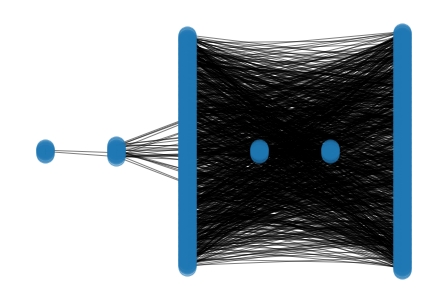

In [271]:
pos = nx.multipartite_layout(G, subset_key="block")
nx.draw(G,pos, alpha=0.5)

In [125]:
sizes.tolist()

[7.0, 25.0, 468.0, 13.0, 12.0, 475.0]

# Evaluate score on network with heterogeneous assortative behaviors

Whatever, worry about viz later.  For now, what are the old and new scores for each of these groups?

In [329]:
seed = 23
rng = np.random.default_rng(seed=seed)
G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

# force every node to be connected
# this will make life easier

# where to connect a node from each class
block_map = {
    0:0,
    1:1,
    2:5,
    3:3,
    4:4,
    5:2
}

for i in range(N):
    if G.degree[i] == 0:
        block = block_map[G.nodes[i]["block"]]
        opts = [x for x,y in G.nodes(data=True) if y['block']==block]
        j = rng.choice(opts)
        G.add_edge(i,j)
        
for i in range(N):
    assert G.degree[i] > 0  

In [336]:
# assemble labels for all groups

f = []
m = []

g = []
b = []
s = []

gf = []
bf = []
sf = []

gm = []
bm = []
sm = []

for node in range(N):
    block = G.nodes[node]["block"]
    
    if block < 3:
        f.append(node)
    else:
        m.append(node)
        
    if block % 3 == 0:
        g.append(node)
    elif block % 3 == 1:
        b.append(node)
    else:
        s.append(node)
        
    if block == 0:
        gf.append(node)
        
    if block == 1:
        bf.append(node)
        
    if block == 2:
        sf.append(node)
        
    if block == 3:
        gm.append(node)
        
    if block == 4:
        bm.append(node)
    
    if block == 5:
        sm.append(node)

In [378]:
sizes = sizes.astype(int)
thresholds = thresholds.astype(int)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] >= 3 for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1), weight_a=True)

by_group_new = []

for i in range(len(thresholds) - 1):
    by_group_new.append(assortT[thresholds[i]: thresholds[i+1]].mean())

In [379]:
by_group

[0.821865267734507,
 -0.38115642761803253,
 -0.9881262690957672,
 0.7237064139093655,
 -0.5464395731208891,
 -0.9867526735659667]

In [380]:
by_group_new

[-0.015159657489773881,
 -0.6704766386327289,
 -1.1294280994097425,
 -0.027056101092540974,
 -0.7783092422503032,
 -1.1258255937978512]

In [385]:
# why is the OG score so okay?  Why aren't GF and GM being diluted into disassortativity?
A = nx.convert_matrix.to_scipy_sparse_matrix(G)
edgelist = E
node_attr = M
missingValue = -1

# number of nodes
n = len(node_attr)
# number od nodes with complete attribute
ncomp = (node_attr != missingValue).sum()
# number of edges
m = len(edgelist)
degree = np.array(A.sum(1)).flatten()

D = sparse.diags(1./degree, 0, format='csc')
W = D @ A # every row sums  to 1

c = len(np.unique(node_attr))

# calculate node weights for how "complete" the
# metadata is around the node
Z = np.zeros(n)
Z[node_attr == missingValue] = 1.
Z = (W @ Z) / degree

# indicator array if node has attribute data (or missing)
hasAttribute = node_attr != missingValue

# calculate global expected values
values = np.ones(ncomp)
yi = (hasAttribute).nonzero()[0]
yj = node_attr[hasAttribute]
Y = sparse.coo_matrix((values, (yi, yj)), shape=(n, c)).tocsc()
eij_glob = np.array(Y.T @ (A @ Y).todense())
eij_glob /= np.sum(eij_glob)
ab_glob = np.sum(eij_glob.sum(1)*eij_glob.sum(0)) # this is ar^2 for undirected

In [386]:
ab_glob

0.5000284262263919

In [387]:
eij_glob

array([[0.02167766, 0.48209237],
       [0.48209237, 0.01413761]])

In [388]:
pr=np.arange(0., 1., 0.1)

assortM = np.empty((n, len(pr)))
assortT = np.empty(n)
WY = (W @ Y).tocsc()

i = 0

# calculate for first node
pis, ti, it = calculateRWRrange(W, i, pr, n)
if len(pr) > 1:
    for ii, pri in enumerate(pr):
        pi = pis[:, ii]

        YPI = sparse.coo_matrix((pi[hasAttribute],
                                (node_attr[hasAttribute],
                                 np.arange(n)[hasAttribute])),
                                shape=(c, n)).tocsr()

        e = YPI.dot(WY).toarray()
        print(ii)
        print(e)
        print("\n")
        assortM[i, ii] = e.trace()

0
[[1. 0.]
 [0. 0.]]


1
[[9.99945023e-01 4.99392146e-05]
 [4.59796411e-06 4.39952611e-07]]


2
[[9.99520383e-01 3.98437957e-04]
 [7.37226449e-05 7.45618302e-06]]


3
[[9.98205616e-01 1.37089692e-03]
 [3.82760269e-04 4.07268671e-05]]


4
[[9.95188059e-01 3.39656013e-03]
 [1.27348934e-03 1.41891184e-04]]


5
[[9.89082908e-01 7.14742618e-03]
 [3.37776184e-03 3.91903901e-04]]


6
[[9.77278067e-01 1.38449429e-02]
 [7.92706101e-03 9.49928575e-04]]


7
[[0.95414765 0.02608565]
 [0.0176187  0.002148  ]]


8
[[0.90510519 0.05055946]
 [0.03958639 0.00474896]]


9
[[0.78203024 0.10874497]
 [0.09847979 0.01074501]]




In [389]:
YPI.todense()[:,:10]

matrix([[0.1561516 , 0.09259417, 0.10392136, 0.09808368, 0.15571542,
         0.15571542, 0.00102724, 0.00051048, 0.00308172, 0.00047442],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

In [377]:
M[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Okay, wait I think this actually makes sense.  Here we have neighborhoods that are more assortative compared to a larger, globally disassortative community.  The trouble happens when we have two assortative communities, a big one and a small one.  The small one gets lost.  Wait not sure if this makes sense but let's see what happens when we look at orientation instead of gender.

In [390]:
sizes = sizes.astype(int)
thresholds = thresholds.astype(int)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] % 3 for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1), weight_a=True)

by_group_new = []

for i in range(len(thresholds) - 1):
    by_group_new.append(assortT[thresholds[i]: thresholds[i+1]].mean())

In [391]:
by_group

[0.2035483495944713,
 -2.1058294214628885,
 0.7815428767871787,
 -0.21742557384204428,
 -2.5542140110409246,
 0.7646467295644784]

In [392]:
by_group_new

[0.8597483626277173,
 1.0283607801025885,
 0.030013839770296546,
 1.2650424923027046,
 0.7762078350224839,
 0.029837817249922908]

Okay, weird...  gay women come out moderately assortative but gay men disassortative.  Why?

In [394]:
omega

array([[ 28.5 ,   1.5 ,   0.  ,   0.  ,   0.  ,   0.  ],
       [  1.5 ,  20.25,   0.  ,   0.  ,   8.25,  20.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,  12.  , 914.  ],
       [  0.  ,   0.  ,   0.  ,  28.5 ,   1.5 ,   0.  ],
       [  0.  ,   8.25,  12.  ,   1.5 ,   8.25,   0.  ],
       [  0.  ,  20.  , 914.  ,   0.  ,   0.  ,   0.  ]])

Well they have exactly the same proportions now but there are differences in their neighborhoods due to differences between bi men and women from trying to make the numbers add up.  Let's ditch our last attempts at realism and try to get something that tells a more consistent story.  Sigh.

In [397]:
N = 400
k = 5 # mean degree

# population gender and sexual orientation breakdowns
# from https://news.gallup.com/poll/329708/lgbt-identification-rises-latest-estimate.aspx
# group sizes were adjusted to make things easier

gf = .03 * N / 2
bf = .03 * N / 2
sf = .94 * N / 2
gm = .03 * N / 2
bm = .03 * N / 2
sm = .94 * N / 2

sizes = np.array([gf, bf, sf, gm, bm, sm])
sums = sizes * k

# divide up the edges
omega = np.zeros(shape=(6,6))

# fix things
omega[0,0] = 0.95 * sums[0]
omega[3,3] = 0.95 * sums[3]

# size of overlap must be determined
# from the smaller group size to avoid weirdness
omega[1,5] = 0.4 * sums[1]
omega[5,1] = omega[1,5]

omega[2,4] = 0.4 * sums[4]
omega[4,2] = omega[2,4]

# deduce other values
omega[1,0] = sums[0] - omega[0,0]
omega[0,1] = omega[1,0]

omega[3,4] = sums[3] - omega[3,3]
omega[4,3] = omega[3,4]

# bm -- split remaining edges equally between
# bm and bf
omega[1,4] = (sums[4] - omega[4].sum()) / 2
omega[4,1] = omega[1,4]

omega[4,4] = omega[1,4]

omega[1,1] = sums[1] - omega[1].sum()

omega[5,2] = ((sums[5] - omega[5].sum()) + (sums[2] - omega[2].sum()))/2
omega[2,5] = omega[5,2]

# to do an SBM we need the number of possible edges between each group
# this is different on vs. off the diagonal

p = omega.copy()

for i in range(6):
    # TODO: factor of 2 here?
    p[i, i] = omega[i,i] / (sizes[i] * (sizes[i] - 1))
    
    for j in range(i, 6):
        p[i,j] = omega[i,j] / (sizes[i] * sizes[j])
        p[j,i] = p[i,j]
        
seed = 23
rng = np.random.default_rng(seed=seed)
G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

# force every node to be connected
# this will make life easier

# where to connect a node from each class
block_map = {
    0:0,
    1:1,
    2:5,
    3:3,
    4:4,
    5:2
}

for i in range(N):
    if G.degree[i] == 0:
        block = block_map[G.nodes[i]["block"]]
        opts = [x for x,y in G.nodes(data=True) if y['block']==block]
        j = rng.choice(opts)
        G.add_edge(i,j)
        
for i in range(N):
    assert G.degree[i] > 0
    
sizes = sizes.astype(int)
thresholds = thresholds.astype(int)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] % 3 for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1), weight_a=True)

by_group_new = []

for i in range(len(thresholds) - 1):
    by_group_new.append(assortT[thresholds[i]: thresholds[i+1]].mean())
    
by_group

[0.15778361541858896,
 -0.8479226143909273,
 0.7969068770202533,
 -0.6158913332160179,
 -2.5280406848339987,
 0.8663407471504282]

In [398]:
by_group_new

[1.0360061100673579,
 0.8870254744402771,
 0.0396401782621719,
 1.25163889992363,
 1.100852465085098,
 0.061980487422857174]

How much of this variation is just random?

In [399]:
seed = 234567
rng = np.random.default_rng(seed=seed)
G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

# force every node to be connected
# this will make life easier

# where to connect a node from each class
block_map = {
    0:0,
    1:1,
    2:5,
    3:3,
    4:4,
    5:2
}

for i in range(N):
    if G.degree[i] == 0:
        block = block_map[G.nodes[i]["block"]]
        opts = [x for x,y in G.nodes(data=True) if y['block']==block]
        j = rng.choice(opts)
        G.add_edge(i,j)
        
for i in range(N):
    assert G.degree[i] > 0
    
sizes = sizes.astype(int)
thresholds = thresholds.astype(int)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] % 3 for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1), weight_a=True)

by_group_new = []

for i in range(len(thresholds) - 1):
    by_group_new.append(assortT[thresholds[i]: thresholds[i+1]].mean())
    
by_group

[-0.1926875133868006,
 -0.9993798519094147,
 0.8938481939476834,
 -0.7834703773485453,
 -2.8806489815832337,
 0.887971563287286]

In [400]:
by_group_new

[1.397040996756435,
 0.9294657198617328,
 0.0553460142371867,
 1.1267400334147684,
 1.30687505858733,
 0.05825921896049903]

In [405]:
def run_trial_orientation(p, sizes, thresholds, seed):
    rng = np.random.default_rng(seed=seed)
    G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

    # force every node to be connected
    # this will make life easier

    # where to connect a node from each class
    block_map = {
        0:0,
        1:1,
        2:5,
        3:3,
        4:4,
        5:2
    }

    for i in range(N):
        if G.degree[i] == 0:
            block = block_map[G.nodes[i]["block"]]
            opts = [x for x,y in G.nodes(data=True) if y['block']==block]
            j = rng.choice(opts)
            G.add_edge(i,j)

    for i in range(N):
        assert G.degree[i] > 0

    sizes = sizes.astype(int)
    thresholds = thresholds.astype(int)

    E = nx.convert_matrix.to_pandas_edgelist(G).values
    M = np.array([y["block"] % 3 for x,y in G.nodes(data=True)]).astype(int)

    assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

    by_group = []
    for i in range(len(thresholds) - 1):
        by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

    assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1), weight_a=True)

    by_group_new = []

    for i in range(len(thresholds) - 1):
        by_group_new.append(assortT[thresholds[i]: thresholds[i+1]].mean())
        
    return np.array(by_group), np.array(by_group_new)


seeds = [468, 92, 888888, 9191, 473092, 2300001,88, 3491, 34932,5544333]
results_o = []

for seed in seeds:
    results_o.append(run_trial_orientation(p,sizes,thresholds, seed))

In [423]:
np.vstack([r[0] for r in results_o])[:,3]

array([-0.17831994, -0.37179665,  0.21691255,  0.11507457, -0.04170938,
        0.5188532 ,  0.18528342, -0.00586112, -0.19342456,  0.30586942])

In [412]:
np.vstack([r[0] for r in results_o]).mean(axis=0)

array([ 0.51180536, -0.550448  ,  0.85448762,  0.05508815, -2.04833333,
        0.87091411])

In [416]:
np.vstack([r[0] for r in results_o]).var(axis=0)

array([0.15839729, 0.05767629, 0.00173784, 0.06362587, 0.18438443,
       0.00067448])

In [424]:
def run_trial_gender(p, sizes, thresholds, seed):
    rng = np.random.default_rng(seed=seed)
    G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

    # force every node to be connected
    # this will make life easier

    # where to connect a node from each class
    block_map = {
        0:0,
        1:1,
        2:5,
        3:3,
        4:4,
        5:2
    }

    for i in range(N):
        if G.degree[i] == 0:
            block = block_map[G.nodes[i]["block"]]
            opts = [x for x,y in G.nodes(data=True) if y['block']==block]
            j = rng.choice(opts)
            G.add_edge(i,j)

    for i in range(N):
        assert G.degree[i] > 0

    sizes = sizes.astype(int)
    thresholds = thresholds.astype(int)

    E = nx.convert_matrix.to_pandas_edgelist(G).values
    M = np.array([y["block"] >= 3 for x,y in G.nodes(data=True)]).astype(int)

    assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

    by_group = []
    for i in range(len(thresholds) - 1):
        by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

    assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1), weight_a=True)

    by_group_new = []

    for i in range(len(thresholds) - 1):
        by_group_new.append(assortT[thresholds[i]: thresholds[i+1]].mean())
        
    return np.array(by_group), np.array(by_group_new)


seeds = [468, 92, 888888, 9191, 473092, 2300001,88, 3491, 34932,5544333]
results_g = []

for seed in seeds:
    results_g.append(run_trial_gender(p,sizes,thresholds, seed))

In [426]:
np.vstack([r[0] for r in results_g]).mean(axis=0)

array([ 0.89931247, -0.65138263, -0.99162016,  0.80356409, -0.47396634,
       -0.99183477])

Okay now I am convinced multiscale mixing is fine the way it is and I went down this rabbit hole for no reason.  Let's try one more thing to fuck it up.

In [443]:
seed = 285
rng = np.random.default_rng(seed=285)

def truncated_power_law(gamma, k_0, n, size=None):
    k_0=np.float64(k_0)
    gamma=np.float64(gamma)
    n=np.float64(n)
    
    if size:
        U = rng.uniform(size=size)
    else:
        U = rng.uniform()
        
    return (
        (k_0**(1-gamma) - 
             ( k_0**(1-gamma) - n**(1-gamma) ) * U 
        )**(1/(1-gamma))
    ).astype(int)



C = 20
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes

array([ 10,  10,  11,  11,  11,  12,  12,  14,  16,  17,  20,  21,  21,
        22,  25,  31,  39,  55,  78, 148])

In [444]:
sizes.sum()

584

In [453]:
thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

In [454]:
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())
    
by_group

[0.08568081575685264,
 0.11397523302258902,
 0.1017862345431561,
 0.13583211695446396,
 0.16865426876742542,
 0.1518740432381012,
 0.1814711357515889,
 0.16430437911149562,
 0.10274327828368185,
 0.1762690905741867,
 0.09619463089420914,
 0.1482068701873318,
 0.1333811992322706,
 0.16262979355136611,
 0.182784019230455,
 0.2448762415917513,
 0.2756818994542666,
 0.3681073571257681,
 0.4485869318217935,
 0.617065470842586]

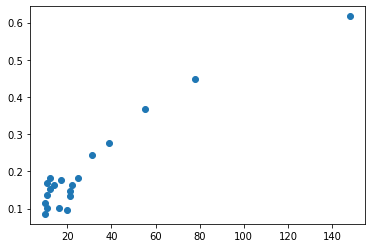

In [455]:
plt.scatter(x=sizes, y=by_group)

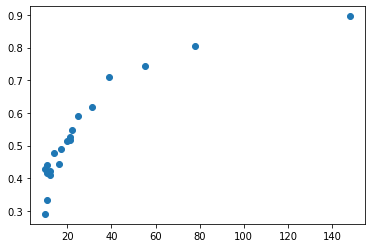

In [458]:
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.5

G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())
    
plt.scatter(x=sizes, y=by_group)

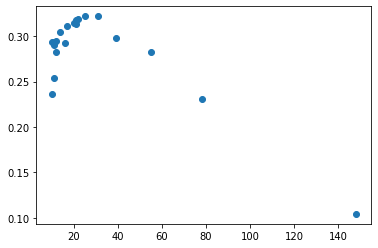

In [459]:
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.5

G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=True)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())
    
plt.scatter(x=sizes, y=by_group)

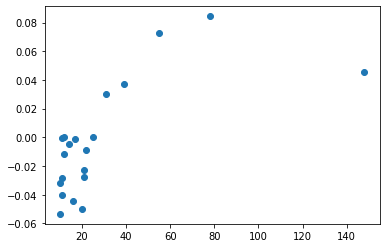

In [460]:
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=True)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())
    
plt.scatter(x=sizes, y=by_group)

In [472]:
C = 20
sizes = truncated_power_law(1.2, 10, 500, size=C)
sizes.sort()

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

sizes

array([ 11,  16,  17,  17,  18,  18,  20,  26,  26,  26,  34,  42,  73,
        86, 134, 350, 368, 471, 478, 478])

In [473]:
sizes.sum()

2709

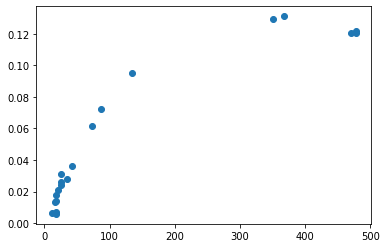

In [474]:
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=True)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())
    
plt.scatter(x=sizes, y=by_group)

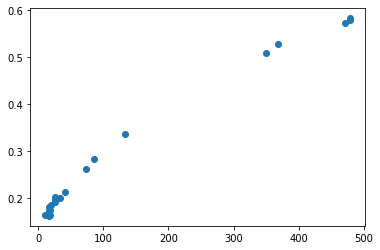

In [475]:
G = sbm(sizes.astype(int).tolist(), p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())
    
plt.scatter(x=sizes, y=by_group)

In [490]:
C

10

In [491]:
sizes = [20,20,20,20, 20,50, 50,50, 100, 250]

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

sizes

[20, 20, 20, 20, 20, 50, 50, 50, 100, 250]

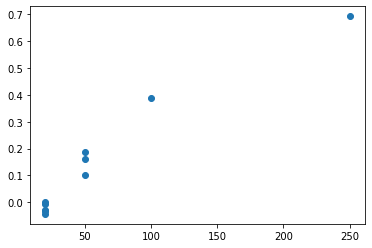

In [492]:
G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

In [494]:
sizes = [20,22,25,28, 20,50, 55,60, 100, 400]

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

sizes

[20, 22, 25, 28, 20, 50, 55, 60, 100, 400]

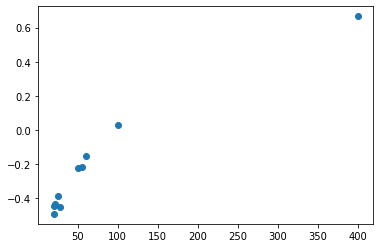

In [497]:
G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

In [498]:
sizes = [10]*10
sizes.append(100)

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

    C = len(sizes)
sizes

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 100]

/Users/rebecca/school/csci5352/Project/MultiscaleMixing/source/lassort/localassort.py:62: RuntimeWarning: divide by zero encountered in true_divide
  D = sparse.diags(1./degree, 0, format='csc')
/Users/rebecca/school/csci5352/Project/MultiscaleMixing/source/lassort/localassort.py:74: RuntimeWarning: invalid value encountered in true_divide
  Z = (W @ Z) / degree
/Users/rebecca/school/csci5352/Project/MultiscaleMixing/source/lassort/localassort.py:121: RuntimeWarning: invalid value encountered in true_divide
  e_gh /= e_gh_sum


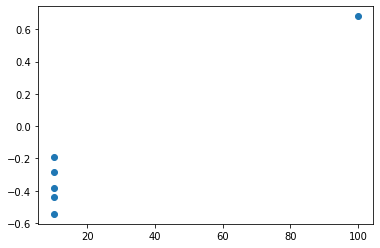

In [499]:


G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

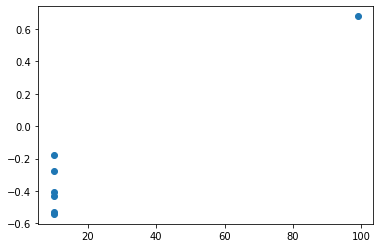

In [501]:
sizes = [10]*10
sizes.append(99)

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

    C = len(sizes)

G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

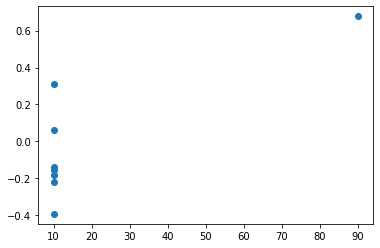

In [502]:
sizes = [10]*10
sizes.append(90)

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

    C = len(sizes)

G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

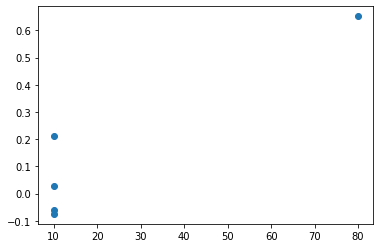

In [503]:
sizes = [10]*10
sizes.append(80)

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

    C = len(sizes)

G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

In [510]:
C = 10
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes = np.append(sizes, sizes.sum())
sizes

array([ 10,  10,  12,  13,  13,  14,  16,  20,  23,  23, 154])

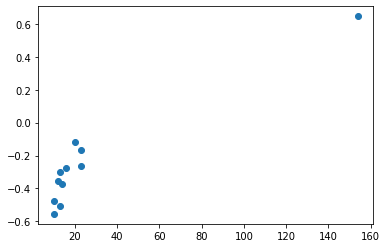

In [511]:
thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.01
for i in range(C):
    p[i,i] = 0.1

    C = len(sizes)

G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

Okay, so I think where the dating network example fails is that it's not noisy enough.  Let's try some disassortatiive networks.

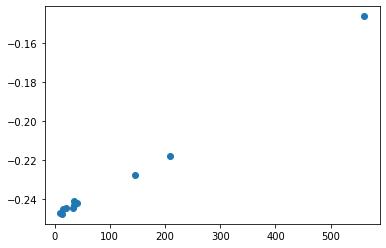

In [512]:
C = 10
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes = np.append(sizes, sizes.sum())

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.05
for i in range(C):
    p[i,i] = 0.01

    C = len(sizes)

G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

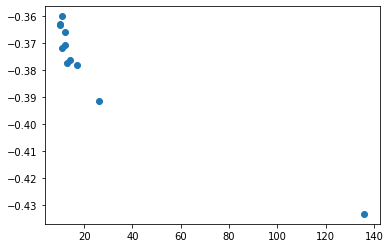

In [513]:
C = 10
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes = np.append(sizes, sizes.sum())

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.05
for i in range(C):
    p[i,i] = 0.01

    C = len(sizes)

G = sbm(sizes, p.tolist(), seed=seed)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=True)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

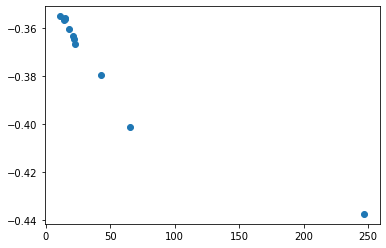

In [514]:
C = 10
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes = np.append(sizes, sizes.sum())

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.05
for i in range(C):
    p[i,i] = 0.01

    C = len(sizes)

G = sbm(sizes, p.tolist(), seed=(seed+24))

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=True)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

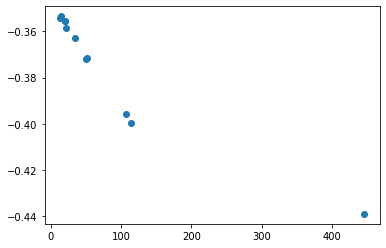

In [515]:
C = 10
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes = np.append(sizes, sizes.sum())

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.05
for i in range(C):
    p[i,i] = 0.01

C = len(sizes)

G = sbm(sizes, p.tolist(), seed=(seed+38))

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=True)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

In [523]:
nx.algorithms.community.modularity(G,[np.where(M==i)[0].tolist() for i in range(C)])

-0.13781064288342448

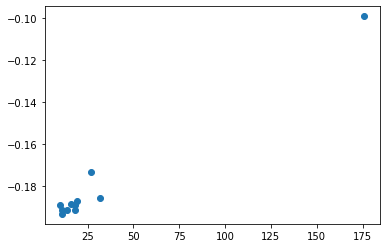

In [524]:
C = 10
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes = np.append(sizes, sizes.sum())

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.05
for i in range(C):
    p[i,i] = 0.01

C = len(sizes)

G = sbm(sizes, p.tolist(), seed=(seed+38))

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

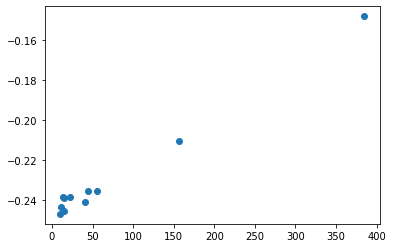

In [526]:
C = 10
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes = np.append(sizes, sizes.sum())

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.05
for i in range(C):
    p[i,i] = 0.01

C = len(sizes)

G = sbm(sizes, p.tolist(), seed=(seed+3))

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

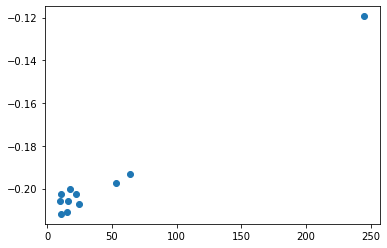

In [528]:
C = 10
sizes = truncated_power_law(2.1, 10, 500, size=C)
sizes.sort()
sizes = np.append(sizes, sizes.sum())

thresholds = np.zeros(len(sizes) + 1)
thresholds[1:] = sizes

for i in range(2, len(thresholds)):
    thresholds[i:] += sizes[i-2]

thresholds = thresholds.astype(int)

C = len(sizes)
p = np.ones((C,C)) * 0.05
for i in range(C):
    p[i,i] = 0.01

C = len(sizes)

G = sbm(sizes, p.tolist(), seed=(seed+30))

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.array([y["block"] for x,y in G.nodes(data=True)]).astype(int)

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1),weight_a=False)

by_group = []
for i in range(len(thresholds) - 1):
    by_group.append(assortT[thresholds[i]: thresholds[i+1]].mean())

plt.scatter(x=sizes, y=by_group)

How does the T value vary based on the class size and comparisons witth otther class sizes? And the p's fuck.  Well let's not worry about the P's right now.  This is an interesting question that merits a new notebook.

Hookay so there is a "real" problem here depending on how you look at it.  Coming from SBM-world, if nodes in class $r$ show a stronger preference for other nodes in class $r$ we expect the score to reflect the strength of that preference even if there are other factors at work.

Two other potential fixes:
1. Just look at class ratios in the personalized pagerank.  How dominant is node j's class in its weighted neighborhood compared to the global network?  This should be great at picking out assortativity but terrible at picking out disassortativity.

2. Only compute multiscale mixing for the dominant node's class.  This prevents us from losing all the stuff from the class differences between the global configuration model and class distributions in the local neighborhood.

3. But I think the best thing is more of a hypothesis testing approach.  H_0: this node's pairs with its own class according to the DC-SBM's best fit.  H1: This node prefers has a different own-class vs. other class pairing prob.

ALSO: Do I want to explore predicting the expected result of the null model?

Yes, I definitely want to.  No, I probably shouldn't.